# Which CREs control cell lineage specific genes

Here, we want to assign the CREs to cell lineage specific genes. We are going to use the regression model from the notebook regression_model.ipynb and the assignment of promoters and enhancers per genes from enhancers_promoters_regression.ipynb. Also, from the gene_expression_clustering.ipynb we are going to be using the information about which genes are most expressed in which cell lineages.

In [1]:
import pandas as pd

# Load the two tables
markers_df = pd.read_csv("marker_genes_by_cell_group.csv")     
cre_df     = pd.read_csv("high_conf_filtered.csv")  

# Merge on the gene symbol
merged = pd.merge(
    markers_df.rename(columns={"Gene": "gene"}),
    cre_df,
    on="gene",
    how="inner"
)

# Now `merged` contains only those CREs tied to the lineage markers.
#    For each lineage, list its unique CREs:
cres_by_lineage = (
    merged
    .groupby("Group")["peak_ID"]
    .unique()
    .apply(list)
    .reset_index(name="CREs")
)

# Count or rank them by predictive weight:
merged["abs_coef"] = merged["coefficient"].abs()
top_cres = (
    merged
    .groupby("Group")
    .apply(lambda df:
        df.groupby("peak_ID")["abs_coef"]
          .sum()
          .nlargest(10)
          .index
          .tolist()
    )
    .reset_index(name="Top_10_Cres")
)

print(cres_by_lineage)
print(top_cres)


        Group                                               CREs
0  Progenitor  [ImmGenATAC1219.peak_387842, ImmGenATAC1219.pe...
1        Tact  [ImmGenATAC1219.peak_21029, ImmGenATAC1219.pea...
2         abT  [ImmGenATAC1219.peak_508000, ImmGenATAC1219.pe...
        Group                                        Top_10_Cres
0  Progenitor  [ImmGenATAC1219.peak_215414, ImmGenATAC1219.pe...
1        Tact  [ImmGenATAC1219.peak_212966, ImmGenATAC1219.pe...
2         abT  [ImmGenATAC1219.peak_212966, ImmGenATAC1219.pe...


C:\Users\kalin_p\AppData\Local\Temp\ipykernel_9756\157100940.py:30: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda df:


In [10]:
merged.head()

,Group,gene,Unnamed: 0,peak_ID,coefficient,r2,distance_to_tss,role,abs_coef
0,Progenitor,Flt3,41052,ImmGenATAC1219.peak_387842,-2.472014,0.847262,981.0,repressor,2.472014
1,Progenitor,Flt3,41053,ImmGenATAC1219.peak_387850,40.321731,0.847262,17275.0,activator,40.321731
2,Progenitor,Flt3,41054,ImmGenATAC1219.peak_387852,-2.587953,0.847262,18772.0,repressor,2.587953
3,Progenitor,Flt3,41055,ImmGenATAC1219.peak_387871,11.187570,0.847262,32993.0,activator,11.187570
4,Progenitor,Flt3,41056,ImmGenATAC1219.peak_387896,16.869341,0.847262,60.0,activator,16.869341


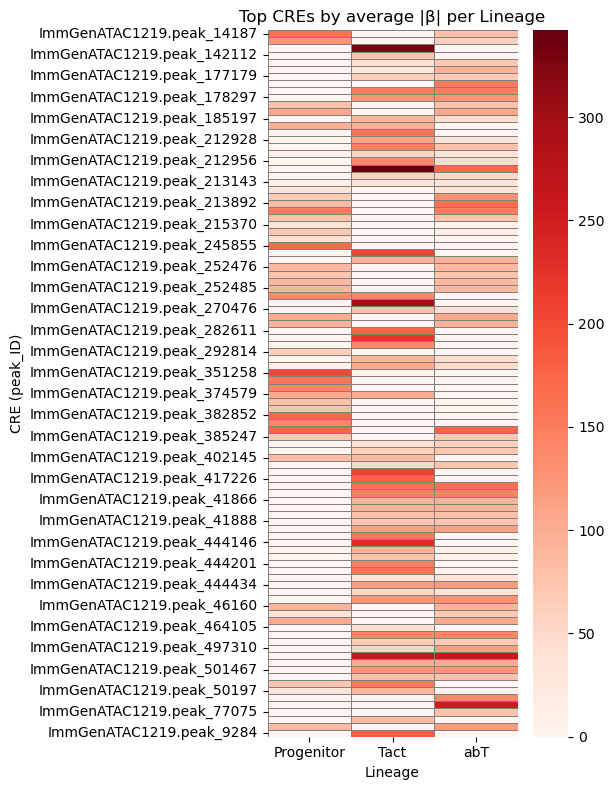

In [9]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# assume `merged` from before has columns Group, peak_ID, abs_coef
# pick top 20 CREs across all lineages
top_peaks = (
    merged
    .groupby("peak_ID")["abs_coef"]
    .sum()
    .nlargest(100)
    .index
)

# build pivot table
heat = (
    merged[merged["peak_ID"].isin(top_peaks)]
    .groupby(["peak_ID","Group"])["abs_coef"]
    .mean()
    .unstack(fill_value=0)
)

plt.figure(figsize=(6,8))
sns.heatmap(heat, cmap="Reds", linewidths=.5, linecolor="gray")
plt.xlabel("Lineage")
plt.ylabel("CRE (peak_ID)")
plt.title("Top CREs by average |β| per Lineage")
plt.tight_layout()
plt.show()


**Fig. 1: Top CREs per average cell lineage**

This heatmap is showing us, for each of our top CREs (rows = peak_ID) and each cell-lineage (columns = Progenitor, Tact, abT), the average absolute regression coefficient ∣𝛽∣ from the peak→expression model. In other words, the deeper the red, the more strongly that CRE predicts the expression of the lineage’s marker genes.

The vertical bar on the right is the color scale, showing us how the shades of red map to numerical values of the heatmap cells. In this case it’s plotting the average absolute regression coefficient ∣β∣ for each CRE–lineage pairing. Lighter red (near zero) means that CRE has almost no predictive weight for that lineage’s marker genes. Darker colors (up toward 300–350 in your figure) means that CRE carried very strong predictive weight—in other words, it was a highly influential regulator of those lineage-specific genes.